# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from transformers import AutoModel, AutoTokenizer

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Данные

In [3]:
data = pd.read_csv("lenta_sample.csv")
data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29


In [4]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

### Датасет

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

### Классификатор

In [6]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, tokenizer, num_classes, method="cls"):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)
        self.method = method
        if self.method == "cls":
            print("The classifier uses the first hidden state (cls) outputted from BERT's last layer.")
        elif self.method == "avg_pool":
            print("The classifier uses the average across hidden states of all tokens outputted from BERT's last layer.")
        else:
            raise ValueError("Expected 'cls' or 'avg_pool' as method")

    def forward(self, texts):
        mask = (texts != self.tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        if self.method == "cls":
            # берем самое первое состояние (cls)
            hidden_for_classifier = hidden[:, 0]
        elif self.method == "avg_pool":
            # берем среднее по всем состояниям
            hidden_for_classifier = hidden.mean(dim=1)

        outputs = self.act(self.fc(self.drop(hidden_for_classifier)))

        return outputs

### Функции для train, evaluate, predict

In [7]:
def train(model, iterator, optimizer, criterion, print_every=1000):
    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))

        loss.backward()
        optimizer.step()
        preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f"Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}")

    return np.mean(epoch_f1)

In [8]:
def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            y_true = ys.tolist()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)

In [9]:
def predict(model, iterator):
    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

### Инициализация необходимых элементов для обучения

In [10]:
def training_init(model_id, max_len=512, method="cls", freeze_bert=False):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model_bert = AutoModel.from_pretrained(model_id)

    if freeze_bert:
        for param in model_bert.parameters():
            param.requires_grad = False

    training_set = Dataset(tokenizer, max_len, train_texts, train_targets)
    training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
    valid_set = Dataset(tokenizer, max_len, valid_texts, valid_targets)
    valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

    model = CLF(model_bert, tokenizer, len(label2id), method)
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.NLLLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    return model, training_generator, valid_generator, optimizer, criterion

### ModernBERT-base (дообучение целиком)

In [11]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "answerdotai/ModernBERT-base"
)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [12]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [13]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.06451612903225806
1
Eval -  0.06451612903225806
2
Eval -  0.12903225806451613
3
Eval -  0.03225806451612903
4
Eval -  0.06451612903225806
5
Eval -  0.0967741935483871
6
Eval -  0.25806451612903225
7
Eval -  0.22580645161290322
8
Eval -  0.22580645161290322
9
Eval -  0.2903225806451613
10
Eval -  0.22580645161290322
11
Eval -  0.22580645161290322
12
Eval -  0.25806451612903225
13
Eval -  0.22580645161290322
14
Eval -  0.22580645161290322
15
Eval -  0.3225806451612903
16
Eval -  0.2903225806451613
17
Eval -  0.25806451612903225
18
Eval -  0.3225806451612903
19
Eval -  0.3225806451612903
20
Eval -  0.2903225806451613
21
Eval -  0.3225806451612903
22
Eval -  0.3225806451612903
23
Eval -  0.3225806451612903
24
Eval -  0.3225806451612903
25
Eval -  0.3225806451612903
26
Eval -  0.3225806451612903
27
Eval -  0.3225806451612903
28
Eval -  0.3225806451612903
29
Eval -  0.3225806451612903


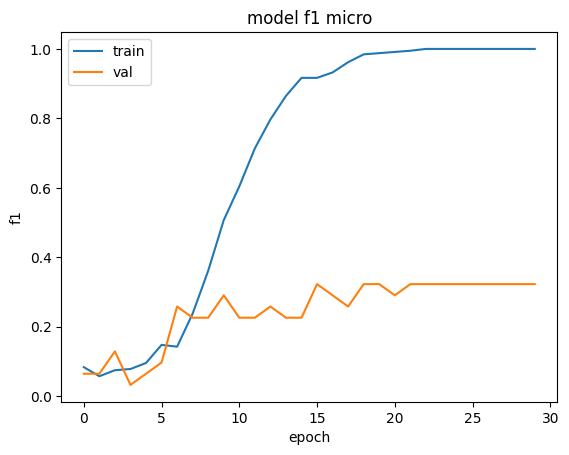

In [14]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [15]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.60      0.75      0.67         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.50      0.33      0.40         3
          13       1.00      0.60      0.75         5
          15       0.00      0.00      0.00         1
          16       1.00      0.25      0.40         4

    accuracy                           0.32        31
   macro avg       0.27      0.21      0.22        31
weighted avg       0.46      0.32      0.35        31



Микроусредненная f-мера (т.е. accuracy, потому что классификация не multilabel) превысила 0.32, но только у 5 из 17 классов метрики ненулевые. Модель сильно переобучилась под трейн (на нем после 23-й эпохи accuracy = 1)

In [16]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### RuModernBERT-base (дообучение целиком)

In [17]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base"
)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [18]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [19]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.4838709677419355
1
Eval -  0.45161290322580644
2
Eval -  0.6451612903225806
3
Eval -  0.7096774193548387
4
Eval -  0.7096774193548387
5
Eval -  0.6129032258064516
6
Eval -  0.6774193548387096
7
Eval -  0.7096774193548387
8
Eval -  0.7096774193548387
9
Eval -  0.7096774193548387
10
Eval -  0.7096774193548387
11
Eval -  0.6774193548387096
12
Eval -  0.6451612903225806
13
Eval -  0.6774193548387096
14
Eval -  0.7096774193548387
15
Eval -  0.6774193548387096
16
Eval -  0.6774193548387096
17
Eval -  0.6774193548387096
18
Eval -  0.6774193548387096
19
Eval -  0.6774193548387096
20
Eval -  0.6774193548387096
21
Eval -  0.6774193548387096
22
Eval -  0.6774193548387096
23
Eval -  0.6774193548387096
24
Eval -  0.6774193548387096
25
Eval -  0.6774193548387096
26
Eval -  0.6774193548387096
27
Eval -  0.6774193548387096
28
Eval -  0.6774193548387096
29
Eval -  0.6774193548387096


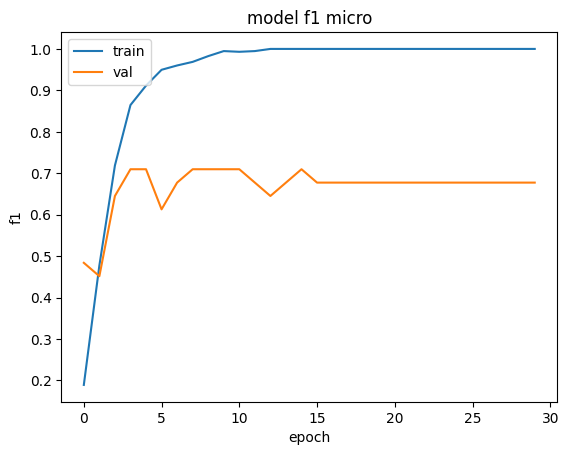

In [20]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [21]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.67      1.00      0.80         2
           2       0.50      1.00      0.67         1
           4       1.00      0.67      0.80         3
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         1
           7       1.00      0.50      0.67         2
           8       0.67      1.00      0.80         4
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       1.00      0.33      0.50         3
          13       0.67      0.80      0.73         5
          15       0.00      0.00      0.00         1
          16       1.00      0.75      0.86         4

    accuracy                           0.68        31
   macro avg       0.64      0.61      0.58        31
weighted avg       0.75      0.68      0.67        31



Accuracy превысила 0.67 - в ~2 раза больше, чем у ModernBert (т.к. ModernBert, в отличие от RuModernBert, не была предобучена на русский язык). Ненулевые метрики теперь у 11 классов из 17. Модель ожидаемо переобучилась под трейн раньше, чем ModernBert (уже на 12-й эпохе accuracy = 1)

In [22]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### ModernBERT-base (дообучение только fully-connected слоя для классификации)

In [23]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "answerdotai/ModernBERT-base", freeze_bert=True
)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [24]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [25]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.0967741935483871
1
Eval -  0.06451612903225806
2
Eval -  0.06451612903225806
3
Eval -  0.06451612903225806
4
Eval -  0.06451612903225806
5
Eval -  0.0967741935483871
6
Eval -  0.12903225806451613
7
Eval -  0.0967741935483871
8
Eval -  0.12903225806451613
9
Eval -  0.12903225806451613
10
Eval -  0.12903225806451613
11
Eval -  0.12903225806451613
12
Eval -  0.0967741935483871
13
Eval -  0.0967741935483871
14
Eval -  0.0967741935483871
15
Eval -  0.0967741935483871
16
Eval -  0.16129032258064516
17
Eval -  0.16129032258064516
18
Eval -  0.16129032258064516
19
Eval -  0.16129032258064516
20
Eval -  0.12903225806451613
21
Eval -  0.1935483870967742
22
Eval -  0.12903225806451613
23
Eval -  0.12903225806451613
24
Eval -  0.12903225806451613
25
Eval -  0.16129032258064516
26
Eval -  0.16129032258064516
27
Eval -  0.16129032258064516
28
Eval -  0.16129032258064516
29
Eval -  0.12903225806451613


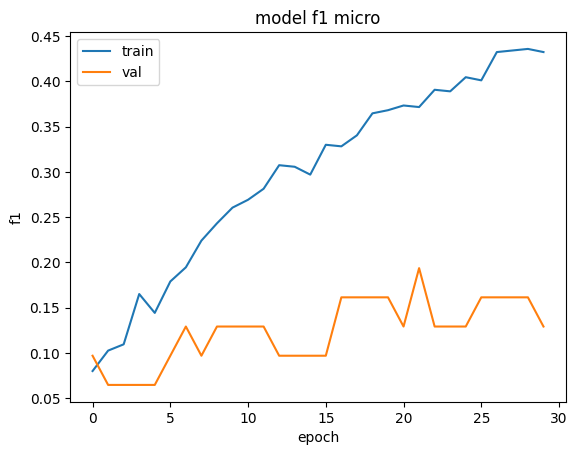

In [26]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [27]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.20      1.00      0.33         2
           2       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.13        31
   macro avg       0.09      0.21      0.12        31
weighted avg       0.05      0.13      0.06        31



Качество намного ниже, чем у моделей, которые обучались без заморозки берта. Ненулевые поклассовые метрики только у 3 классов. Переобучение наблюдается, но за 30 эпох модель смогла подогнаться только под accuracy = ~0.43 на трейне, и график accuracy не вышел на плато.

In [28]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### RuModernBERT-base (дообучение только fully-connected слоя для классификации)

In [29]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base", freeze_bert=True
)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [30]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [31]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.12903225806451613
1
Eval -  0.12903225806451613
2
Eval -  0.06451612903225806
3
Eval -  0.03225806451612903
4
Eval -  0.03225806451612903
5
Eval -  0.06451612903225806
6
Eval -  0.06451612903225806
7
Eval -  0.12903225806451613
8
Eval -  0.06451612903225806
9
Eval -  0.03225806451612903
10
Eval -  0.06451612903225806
11
Eval -  0.03225806451612903
12
Eval -  0.03225806451612903
13
Eval -  0.0967741935483871
14
Eval -  0.06451612903225806
15
Eval -  0.06451612903225806
16
Eval -  0.12903225806451613
17
Eval -  0.06451612903225806
18
Eval -  0.06451612903225806
19
Eval -  0.06451612903225806
20
Eval -  0.0967741935483871
21
Eval -  0.12903225806451613
22
Eval -  0.0967741935483871
23
Eval -  0.06451612903225806
24
Eval -  0.06451612903225806
25
Eval -  0.06451612903225806
26
Eval -  0.06451612903225806
27
Eval -  0.0967741935483871
28
Eval -  0.06451612903225806
29
Eval -  0.06451612903225806


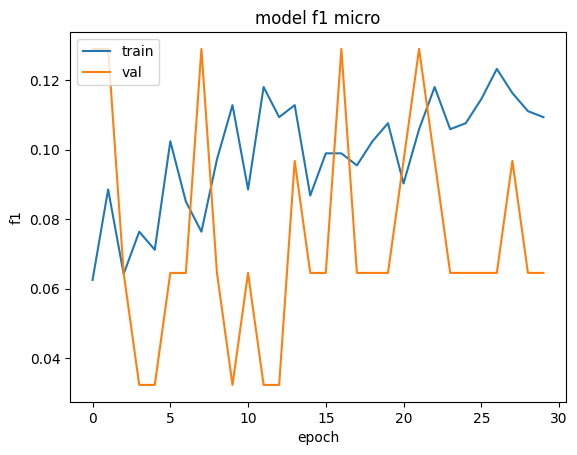

In [32]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [33]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.05      0.50      0.09         2
           2       0.09      1.00      0.17         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.06        31
   macro avg       0.01      0.11      0.02        31
weighted avg       0.01      0.06      0.01        31



Accuracy даже на трейне едва перешагнула отметку 0.1. Модели не хватает эпох, в конце тетрадки попробую переобучить с бóльшим количеством эпох.

In [34]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### RuModernBERT-base (дообучение целиком, усредненный hidden state)

In [35]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base", method="avg_pool"
)

The classifier uses the average across hidden states of all tokens outputted from BERT's last layer.


In [36]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [37]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.0967741935483871
1
Eval -  0.12903225806451613
2
Eval -  0.16129032258064516
3
Eval -  0.1935483870967742
4
Eval -  0.2903225806451613
5
Eval -  0.3870967741935484
6
Eval -  0.5161290322580645
7
Eval -  0.4838709677419355
8
Eval -  0.5483870967741935
9
Eval -  0.4838709677419355
10
Eval -  0.5806451612903226
11
Eval -  0.5806451612903226
12
Eval -  0.5483870967741935
13
Eval -  0.5483870967741935
14
Eval -  0.5483870967741935
15
Eval -  0.6129032258064516
16
Eval -  0.6129032258064516
17
Eval -  0.6129032258064516
18
Eval -  0.6129032258064516
19
Eval -  0.6129032258064516
20
Eval -  0.6129032258064516
21
Eval -  0.6129032258064516
22
Eval -  0.6129032258064516
23
Eval -  0.6129032258064516
24
Eval -  0.6129032258064516
25
Eval -  0.6129032258064516
26
Eval -  0.6129032258064516
27
Eval -  0.6129032258064516
28
Eval -  0.6129032258064516
29
Eval -  0.6129032258064516


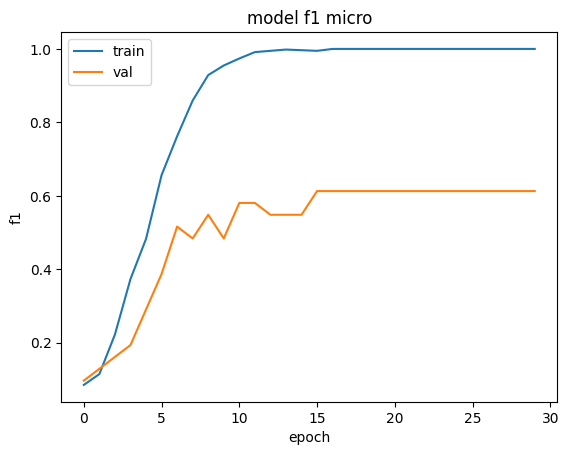

In [38]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [39]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1
           4       1.00      0.33      0.50         3
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         2
           8       0.80      1.00      0.89         4
           9       0.33      1.00      0.50         1
          10       1.00      1.00      1.00         1
          11       0.50      0.33      0.40         3
          12       0.00      0.00      0.00         0
          13       0.71      1.00      0.83         5
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       1.00      0.50      0.67         4

    accuracy                           0.61        31
   macro avg       0.55   

Сравнение по метрикам RuModernBert с подачей в классификатор только hidden state для cls (слева) vs. усреднения по всем hidden state (справа). Общие метрики у второй модели ниже.

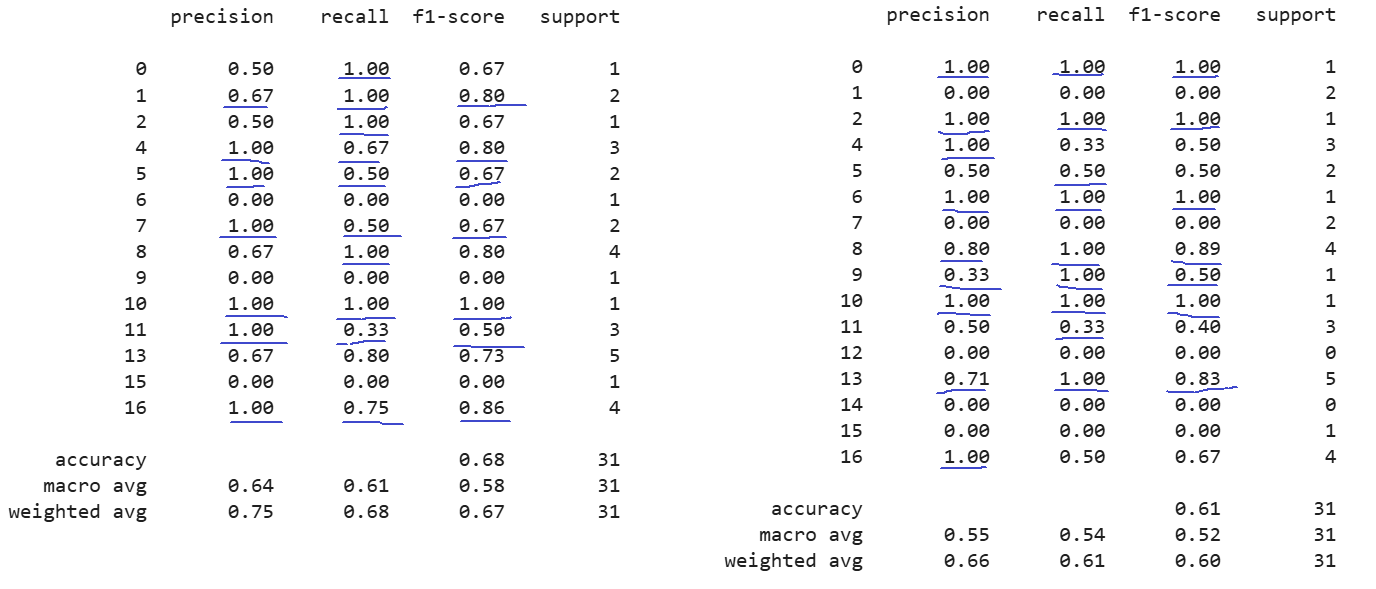

Классов, которые распознаются первой моделью лучше, чем второй, и наоборот, поровну:

для первой (только cls) - 1, 4, 5, 7, 11, 16.
для второй (усреднение) - 0, 2, 6, 8, 9, 13.

In [40]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### RuModernBERT-base (дообучение только fully-connected слоя для классификации)

50 эпох - попытаться выбить скор выше 0.129

In [41]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base", freeze_bert=True
)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [42]:
print("Percentage of trainable params:")
print("{0:.10f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [43]:
f1s = []
f1s_eval = []

for i in range(50):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.03225806451612903
1
Eval -  0.03225806451612903
2
Eval -  0.03225806451612903
3
Eval -  0.06451612903225806
4
Eval -  0.0967741935483871
5
Eval -  0.06451612903225806
6
Eval -  0.0967741935483871
7
Eval -  0.0967741935483871
8
Eval -  0.03225806451612903
9
Eval -  0.0967741935483871
10
Eval -  0.03225806451612903
11
Eval -  0.06451612903225806
12
Eval -  0.0967741935483871
13
Eval -  0.0967741935483871
14
Eval -  0.06451612903225806
15
Eval -  0.03225806451612903
16
Eval -  0.03225806451612903
17
Eval -  0.06451612903225806
18
Eval -  0.06451612903225806
19
Eval -  0.0967741935483871
20
Eval -  0.06451612903225806
21
Eval -  0.06451612903225806
22
Eval -  0.06451612903225806
23
Eval -  0.06451612903225806
24
Eval -  0.12903225806451613
25
Eval -  0.12903225806451613
26
Eval -  0.06451612903225806
27
Eval -  0.0967741935483871
28
Eval -  0.06451612903225806
29
Eval -  0.0967741935483871
30
Eval -  0.12903225806451613
31
Eval -  0.06451612903225806
32
Eval -  0.09677419354838

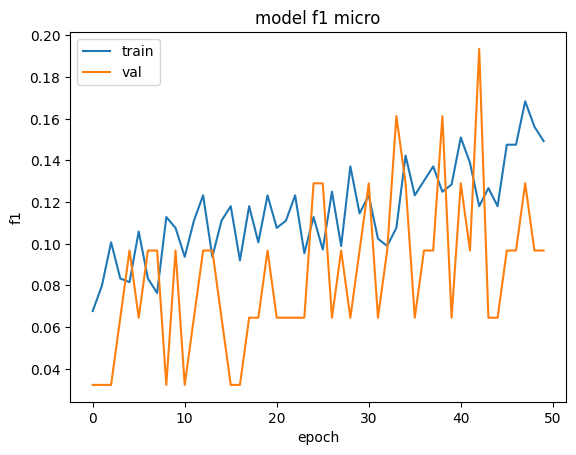

In [44]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

Accuracy даже на трейне не превысило 0.17.

In [45]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.05      0.50      0.08         2
           2       0.25      1.00      0.40         1
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.10        31
   macro avg       0.06      0.13      0.06        31
weighted avg       0.06      0.10      0.06        31

